# 나의 첫 번째 캐글 경진대회 🐬

## 1. 필요한 라이브러리 불러오기

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_forat = 'retina'

import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

## 2. 데이터 불러오기
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, "train.csv")
test_data_path = join(data_dir, "test.csv")

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

print(train.shape, test.shape)

(15035, 21) (6468, 20)


In [3]:
train.head()

id             date     price  bedrooms  bathrooms  sqft_living  sqft_lot  \
0   0  20141013T000000  221900.0         3       1.00         1180      5650   
1   1  20150225T000000  180000.0         2       1.00          770     10000   
2   2  20150218T000000  510000.0         3       2.00         1680      8080   
3   3  20140627T000000  257500.0         3       2.25         1715      6819   
4   4  20150115T000000  291850.0         3       1.50         1060      9711   

   floors  waterfront  view  ...  grade  sqft_above  sqft_basement  yr_built  \
0     1.0           0     0  ...      7        1180              0      1955   
1     1.0           0     0  ...      6         770              0      1933   
2     1.0           0     0  ...      8        1680              0      1987   
3     2.0           0     0  ...      7        1715              0      1995   
4     1.0           0     0  ...      7        1060              0      1963   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0             0    98178  47.5112 -122.257           1340        5650  
1             0    98028  47.7379 -122.233           2720        8062  
2             0    98074  47.6168 -122.045           1800        7503  
3             0    98003  47.3097 -122.327           2238        6819  
4             0    98198  47.4095 -122.315           1650        9711  

[5 rows x 21 columns]

id 컬럼은 인덱스를 나타내는 큰 의미 없는 feature처럼 보인다. 제거해주자.

In [4]:
# id 컬럼 삭제
del train['id']
print(train.columns)

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


date 컬럼은 길이가 꽤나 긴데 가독성이 떨어지므로 여기서 연/월 데이터만 사용하자.

In [5]:
# date 컬럼 수정
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

date     price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0  201410  221900.0         3       1.00         1180      5650     1.0   
1  201502  180000.0         2       1.00          770     10000     1.0   
2  201502  510000.0         3       2.00         1680      8080     1.0   
3  201406  257500.0         3       2.25         1715      6819     2.0   
4  201501  291850.0         3       1.50         1060      9711     1.0   

   waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  \
0           0     0          3      7        1180              0      1955   
1           0     0          3      6         770              0      1933   
2           0     0          3      8        1680              0      1987   
3           0     0          3      7        1715              0      1995   
4           0     0          3      7        1060              0      1963   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0             0    98178  47.5112 -122.257           1340        5650  
1             0    98028  47.7379 -122.233           2720        8062  
2             0    98074  47.6168 -122.045           1800        7503  
3             0    98003  47.3097 -122.327           2238        6819  
4             0    98198  47.4095 -122.315           1650        9711

test 데이터셋에서도 train과 마찬가지로 id컬럼은 제거하고, date 컬럼을 변경해준다.

In [6]:
# test셋에서도 똑같이
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)
del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


우리가 찾고자 하는 feature은 'price'이다. <br/>
이 label 데이터를 y라는 변수로 따로 분리하자.

In [7]:
# target data 분리
y = train['price']
del train['price']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


라벨 제거 후 컬럼 수 똑같이 맞춰진 것 확인 가능

In [8]:
print(train.shape, test.shape)

(15035, 19) (6468, 19)


In [9]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

### 가격 그래프 그림 그려보기 (kdeplot)

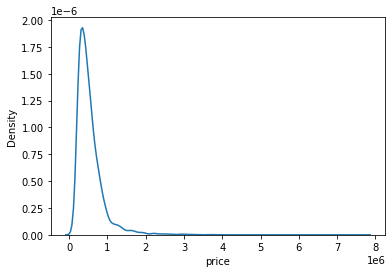

In [10]:
sns.kdeplot(y)
plt.show()

### * 로그 변환

- 위 price 그래프의 x축을 보면 0에서 10^3에 대부분의 값들이 모여있고 아주 소수의 집들이 굉장히 높은 가격을 보인다.
- 이 분포에 `log 변환`을 취하면, 왼쪽 0에 가깝게 모인 데이터는 보다 넓고 고르게 퍼질 것이고, 오른쪽으로 얇고 넓게 퍼진 값들은 작은 범위로 모여 전체 분포가 `정규분포` 형상을 띄게 될 것이다.

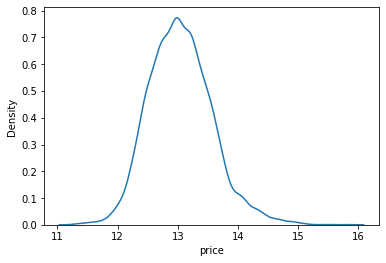

In [11]:
y = np.log1p(y) # ln(1+y)

sns.kdeplot(y)
plt.show()

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

-> 모두 다 정수형, 실수형 변수로 이루어진 것 확인 가능

## 3. RMSE 계산
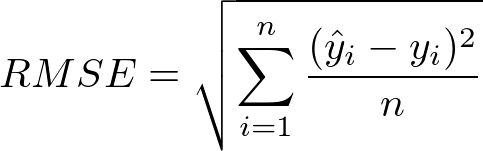
위에서 y값에 대해 log 변환을 취해주었다. <br/>
실제 rmse 값을 계산하기 위해선 원대래도 다시 exp를 취해줘야 한다.

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

## 4. 모델 생성하기
### 블렌딩(blending)
: 하나의개별 모델을 사용하는 것이 아닌 다양한 여러 모델을 종합해 결과를 얻는 기법
- 앙상블(ensemble) 기법이라고도 한다.

### (1) 보팅(voting)
- 여러 모델이 분류해 낸 결과를 다수결 투표를 통해 최종 결과를 선택하는 방법

### (2) 애버리징(Averaging)
- 각 모델이 계산해 낸 실숫값들을 평균 or 가중평균하여 사용하는 방법.
- 회귀 문제에서 사용함

- XGBRegressor, LGBMRegressor, GradientBoostingRegressor, RandomForestRegressor 4가지 모델 이용
- 모델 인스턴스를 생성한 후 models라는 리스트에 넣어주었다.

In [14]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

random_state=2022 # 고정값 세팅

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [56]:
# gboost.__class__.__name__ # 모델의 이름은 클래스의 __name__ 속성에 접근해 얻을 수 있다.

In [15]:
def get_scores(models, train, y):
    df = {}

    for model in models:
        model_name = model.__class__.__name__ # 모델 이름 획득

        # train, test 데이터셋 분리
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train) # 모델 학습
        y_pred = model.predict(X_test) # 예측
        
        # rmse 저장
        df[model_name] = rmse(y_test, y_pred)
        # dataframe에 저장
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False) # 내림차순 정렬
    
    return score_df

In [16]:
get_scores(models, train, y)

RMSE
RandomForestRegressor      135139.591426
GradientBoostingRegressor  130361.233685
XGBRegressor               127865.518649
LGBMRegressor              120099.067237

# 5. 그리드 탐색
### 🧤그리드 탐색
- 탐색할 하이퍼 파라미터의 값들을 정해두고, 그 값들로 만들어질 수 있는 모든 조합을 (격자와 같이) 탐색
- 사람이 정해둔 값들로 조합 탐색하므로 최적의 조합 놓칠 수 있음 <br/>

### 🧤랜덤 탐색
- 사람이 탐색할 하이퍼 파라미터의 공간만 정해두고, 그 안에서 랜덤으로 조합을 선택해 탐색하는 방법
- 랜덤으로 탐색하기 때문에 최적의 조합 찾을 수 있지만 가능성 또한 랜덤성에 의존 (보장 x)

### ✔️GridSearchCV
- param_grid: 탐색할 파라미터 종류
- scoring: 모델의 성능을 평가할 지표
- cv: cross validation을 수행하기 위해 train 데이터셋을 나누는 조각의 수
- verbose: 그리드 탐색을 진행하며 진행 과정을 출력해서 보여줄 메시지 양
- n_jobs: 그리드 탐색 진행하며 사용할 CPU 수

In [17]:
from sklearn.model_selection import GridSearchCV

### 하이퍼 파라미터 튜닝
- max_depth: 의사 결정 나무의 깊이 (정수)
- learning_rate: 한 스텝에 이동하는 양을 결정하는 파라미터 (0.0001-0.1)
- n_estimators: 사용하는 개별 모델의 수 (50-100)
- num_leaves: 하나의 LightGBM 트리가 가질 수 있는 최대 잎 수
- boostying_type: 부스팅 방식, gbdt, rf 등의 문자열 입력

In [18]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model,
                         param_grid=param_grid,
                         scoring='neg_mean_squared_error',
                         cv=5,
                         verbose=verbose,
                         n_jobs=n_jobs)
    # 모델 fitting
    grid_model.fit(train, y)
    
    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [19]:
param_grid = {
    'max_depth': [1, 2, 3, 4, 5, 6, 8, 10],
    'learning_rate': [0.0001, 0.001, 0.01, 0.1],
    'n_estimators': [50, 60, 80, 100],
    'num_leaves': [40, 50, 60]
}

### LGBMRegressor

In [20]:
model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits
[CV] END learning_rate=0.0001, max_depth=1, n_estimators=50, num_leaves=40; total time=   0.3s
[CV] END learning_rate=0.0001, max_depth=1, n_estimators=50, num_leaves=60; total time=   0.3s
[CV] END learning_rate=0.0001, max_depth=1, n_estimators=60, num_leaves=40; total time=   0.3s
[CV] END learning_rate=0.0001, max_depth=1, n_estimators=60, num_leaves=60; total time=   0.3s
[CV] END learning_rate=0.0001, max_depth=1, n_estimators=80, num_leaves=40; total time=   0.2s
[CV] END learning_rate=0.0001, max_depth=1, n_estimators=80, num_leaves=50; total time=   0.2s
[CV] END learning_rate=0.0001, max_depth=1, n_estimators=80, num_leaves=60; total time=   0.1s
[CV] END learning_rate=0.0001, max_depth=1, n_estimators=100, num_leaves=40; total time=   0.2s
[CV] END learning_rate=0.0001, max_depth=1, n_estimators=100, num_leaves=50; total time=   0.2s
[CV] END learning_rate=0.0001, max_depth=1, n_estimators=100, num_leaves=50; to

[CV] END learning_rate=0.0001, max_depth=1, n_estimators=50, num_leaves=40; total time=   0.1s
[CV] END learning_rate=0.0001, max_depth=1, n_estimators=50, num_leaves=60; total time=   0.2s
[CV] END learning_rate=0.0001, max_depth=1, n_estimators=60, num_leaves=40; total time=   0.1s
[CV] END learning_rate=0.0001, max_depth=1, n_estimators=60, num_leaves=50; total time=   0.1s
[CV] END learning_rate=0.0001, max_depth=1, n_estimators=60, num_leaves=50; total time=   0.1s
[CV] END learning_rate=0.0001, max_depth=1, n_estimators=60, num_leaves=60; total time=   0.2s
[CV] END learning_rate=0.0001, max_depth=1, n_estimators=80, num_leaves=40; total time=   0.1s
[CV] END learning_rate=0.0001, max_depth=1, n_estimators=80, num_leaves=50; total time=   0.2s
[CV] END learning_rate=0.0001, max_depth=1, n_estimators=80, num_leaves=50; total time=   0.3s
[CV] END learning_rate=0.0001, max_depth=1, n_estimators=100, num_leaves=40; total time=   0.2s
[CV] END learning_rate=0.0001, max_depth=1, n_est

[CV] END learning_rate=0.0001, max_depth=1, n_estimators=50, num_leaves=40; total time=   0.1s
[CV] END learning_rate=0.0001, max_depth=1, n_estimators=60, num_leaves=50; total time=   0.1s
[CV] END learning_rate=0.0001, max_depth=1, n_estimators=60, num_leaves=60; total time=   0.2s
[CV] END learning_rate=0.0001, max_depth=1, n_estimators=60, num_leaves=60; total time=   0.1s
[CV] END learning_rate=0.0001, max_depth=1, n_estimators=80, num_leaves=40; total time=   0.3s
[CV] END learning_rate=0.0001, max_depth=1, n_estimators=80, num_leaves=60; total time=   0.3s
[CV] END learning_rate=0.0001, max_depth=1, n_estimators=100, num_leaves=40; total time=   0.3s
[CV] END learning_rate=0.0001, max_depth=1, n_estimators=100, num_leaves=60; total time=   0.4s
[CV] END learning_rate=0.0001, max_depth=2, n_estimators=50, num_leaves=40; total time=   0.3s
[CV] END learning_rate=0.0001, max_depth=2, n_estimators=50, num_leaves=60; total time=   0.3s
[CV] END learning_rate=0.0001, max_depth=2, n_es

[CV] END learning_rate=0.0001, max_depth=8, n_estimators=80, num_leaves=60; total time=   1.3s
[CV] END learning_rate=0.0001, max_depth=8, n_estimators=100, num_leaves=40; total time=   1.5s
[CV] END learning_rate=0.0001, max_depth=8, n_estimators=100, num_leaves=60; total time=   1.7s
[CV] END learning_rate=0.0001, max_depth=10, n_estimators=50, num_leaves=50; total time=   0.9s
[CV] END learning_rate=0.0001, max_depth=10, n_estimators=60, num_leaves=40; total time=   0.8s
[CV] END learning_rate=0.0001, max_depth=10, n_estimators=60, num_leaves=50; total time=   0.7s
[CV] END learning_rate=0.0001, max_depth=10, n_estimators=60, num_leaves=60; total time=   0.7s
[CV] END learning_rate=0.0001, max_depth=10, n_estimators=80, num_leaves=40; total time=   0.5s
[CV] END learning_rate=0.0001, max_depth=10, n_estimators=80, num_leaves=50; total time=   0.7s
[CV] END learning_rate=0.0001, max_depth=10, n_estimators=80, num_leaves=60; total time=   0.7s
[CV] END learning_rate=0.0001, max_depth=

[CV] END learning_rate=0.0001, max_depth=10, n_estimators=50, num_leaves=60; total time=   0.5s
[CV] END learning_rate=0.0001, max_depth=10, n_estimators=60, num_leaves=40; total time=   0.7s
[CV] END learning_rate=0.0001, max_depth=10, n_estimators=60, num_leaves=60; total time=   0.5s
[CV] END learning_rate=0.0001, max_depth=10, n_estimators=60, num_leaves=60; total time=   0.7s
[CV] END learning_rate=0.0001, max_depth=10, n_estimators=80, num_leaves=40; total time=   0.6s
[CV] END learning_rate=0.0001, max_depth=10, n_estimators=80, num_leaves=50; total time=   0.7s
[CV] END learning_rate=0.0001, max_depth=10, n_estimators=80, num_leaves=60; total time=   0.7s
[CV] END learning_rate=0.0001, max_depth=10, n_estimators=80, num_leaves=60; total time=   0.7s
[CV] END learning_rate=0.0001, max_depth=10, n_estimators=100, num_leaves=40; total time=   0.7s
[CV] END learning_rate=0.0001, max_depth=10, n_estimators=100, num_leaves=50; total time=   1.4s
[CV] END learning_rate=0.001, max_dept

[CV] END learning_rate=0.0001, max_depth=10, n_estimators=80, num_leaves=40; total time=   1.2s
[CV] END learning_rate=0.0001, max_depth=10, n_estimators=80, num_leaves=50; total time=   1.4s
[CV] END learning_rate=0.0001, max_depth=10, n_estimators=100, num_leaves=40; total time=   0.9s
[CV] END learning_rate=0.0001, max_depth=10, n_estimators=100, num_leaves=50; total time=   1.0s
[CV] END learning_rate=0.0001, max_depth=10, n_estimators=100, num_leaves=60; total time=   0.9s
[CV] END learning_rate=0.001, max_depth=1, n_estimators=50, num_leaves=50; total time=   0.1s
[CV] END learning_rate=0.001, max_depth=1, n_estimators=50, num_leaves=50; total time=   0.2s
[CV] END learning_rate=0.001, max_depth=1, n_estimators=50, num_leaves=60; total time=   0.1s
[CV] END learning_rate=0.001, max_depth=1, n_estimators=60, num_leaves=40; total time=   0.3s
[CV] END learning_rate=0.001, max_depth=1, n_estimators=60, num_leaves=60; total time=   0.3s
[CV] END learning_rate=0.001, max_depth=1, n_es

[CV] END learning_rate=0.001, max_depth=8, n_estimators=60, num_leaves=50; total time=   0.5s
[CV] END learning_rate=0.001, max_depth=8, n_estimators=60, num_leaves=60; total time=   0.6s
[CV] END learning_rate=0.001, max_depth=8, n_estimators=60, num_leaves=60; total time=   0.6s
[CV] END learning_rate=0.001, max_depth=8, n_estimators=80, num_leaves=40; total time=   0.7s
[CV] END learning_rate=0.001, max_depth=8, n_estimators=80, num_leaves=50; total time=   0.6s
[CV] END learning_rate=0.001, max_depth=8, n_estimators=80, num_leaves=60; total time=   0.7s
[CV] END learning_rate=0.001, max_depth=8, n_estimators=100, num_leaves=40; total time=   0.7s
[CV] END learning_rate=0.001, max_depth=8, n_estimators=100, num_leaves=50; total time=   0.9s
[CV] END learning_rate=0.001, max_depth=8, n_estimators=100, num_leaves=50; total time=   0.7s
[CV] END learning_rate=0.001, max_depth=8, n_estimators=100, num_leaves=60; total time=   0.9s
[CV] END learning_rate=0.001, max_depth=10, n_estimators

[CV] END learning_rate=0.001, max_depth=8, n_estimators=50, num_leaves=50; total time=   0.4s
[CV] END learning_rate=0.001, max_depth=8, n_estimators=50, num_leaves=60; total time=   0.5s
[CV] END learning_rate=0.001, max_depth=8, n_estimators=60, num_leaves=40; total time=   0.5s
[CV] END learning_rate=0.001, max_depth=8, n_estimators=60, num_leaves=50; total time=   0.5s
[CV] END learning_rate=0.001, max_depth=8, n_estimators=60, num_leaves=50; total time=   0.5s
[CV] END learning_rate=0.001, max_depth=8, n_estimators=60, num_leaves=60; total time=   0.6s
[CV] END learning_rate=0.001, max_depth=8, n_estimators=80, num_leaves=40; total time=   0.6s
[CV] END learning_rate=0.001, max_depth=8, n_estimators=80, num_leaves=50; total time=   0.6s
[CV] END learning_rate=0.001, max_depth=8, n_estimators=80, num_leaves=60; total time=   1.1s
[CV] END learning_rate=0.001, max_depth=8, n_estimators=100, num_leaves=40; total time=   0.7s
[CV] END learning_rate=0.001, max_depth=8, n_estimators=100

[CV] END learning_rate=0.01, max_depth=5, n_estimators=50, num_leaves=50; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=5, n_estimators=50, num_leaves=60; total time=   0.6s
[CV] END learning_rate=0.01, max_depth=5, n_estimators=60, num_leaves=50; total time=   0.6s
[CV] END learning_rate=0.01, max_depth=5, n_estimators=60, num_leaves=60; total time=   0.7s
[CV] END learning_rate=0.01, max_depth=5, n_estimators=80, num_leaves=50; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=5, n_estimators=80, num_leaves=50; total time=   0.5s
[CV] END learning_rate=0.01, max_depth=5, n_estimators=80, num_leaves=60; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=5, n_estimators=100, num_leaves=40; total time=   0.5s
[CV] END learning_rate=0.01, max_depth=5, n_estimators=100, num_leaves=50; total time=   0.6s
[CV] END learning_rate=0.01, max_depth=5, n_estimators=100, num_leaves=60; total time=   0.5s
[CV] END learning_rate=0.01, max_depth=5, n_estimators=100, num_lea

[CV] END learning_rate=0.01, max_depth=6, n_estimators=100, num_leaves=40; total time=   0.6s
[CV] END learning_rate=0.01, max_depth=6, n_estimators=100, num_leaves=50; total time=   0.7s
[CV] END learning_rate=0.01, max_depth=6, n_estimators=100, num_leaves=60; total time=   0.7s
[CV] END learning_rate=0.01, max_depth=8, n_estimators=50, num_leaves=40; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=8, n_estimators=50, num_leaves=40; total time=   0.5s
[CV] END learning_rate=0.01, max_depth=8, n_estimators=50, num_leaves=50; total time=   0.5s
[CV] END learning_rate=0.01, max_depth=8, n_estimators=50, num_leaves=60; total time=   0.5s
[CV] END learning_rate=0.01, max_depth=8, n_estimators=60, num_leaves=40; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=8, n_estimators=60, num_leaves=50; total time=   0.5s
[CV] END learning_rate=0.01, max_depth=8, n_estimators=60, num_leaves=60; total time=   0.6s
[CV] END learning_rate=0.01, max_depth=8, n_estimators=60, num_leav

[CV] END learning_rate=0.01, max_depth=10, n_estimators=50, num_leaves=50; total time=   0.9s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=60, num_leaves=40; total time=   0.8s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=60, num_leaves=50; total time=   1.0s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=60, num_leaves=60; total time=   0.6s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=80, num_leaves=40; total time=   0.6s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=80, num_leaves=50; total time=   0.7s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=80, num_leaves=60; total time=   0.8s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=40; total time=   1.4s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=50; total time=   0.9s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=60; total time=   1.0s
[CV] END learning_rate=0.1, max_depth=1, n_estimators=50,

learning_rate  max_depth  n_estimators  num_leaves     score     RMSLE
383         0.1000         10           100          60 -0.026908  0.164035
382         0.1000         10           100          50 -0.026911  0.164045
370         0.1000          8           100          50 -0.026977  0.164248
371         0.1000          8           100          60 -0.027001  0.164319
381         0.1000         10           100          40 -0.027037  0.164429
..             ...        ...           ...         ...       ...       ...
4           0.0001          1            60          50 -0.277481  0.526765
3           0.0001          1            60          40 -0.277481  0.526765
2           0.0001          1            50          60 -0.277664  0.526939
1           0.0001          1            50          50 -0.277664  0.526939
0           0.0001          1            50          40 -0.277664  0.526939

[384 rows x 6 columns]

##### 🐬RMSLE: 0.164035 
제일 좋은 조합은 <br/>
learning_rate=0.1, max_depth=10, n_estimators=100, num_leave=60일 때구나! <br/>

In [21]:
model = LGBMRegressor(max_depth=10,
                      learning_rate=0.1,
                      n_estimators=100,
                      num_leaves=60,
                      random_stat=random_state)

#### submission 파일 저장
- 우리의 계산 값들은 log를 씌운 값이다.
- 따라서 sumbmission 파일을 생성할 땐 반드시 expm1()을 취해 원래 스케일로 되돌려야 한다.

In [22]:
def save_submission(model, train, y, test, model_name, rmsle):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [23]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.164035')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.164035.csv saved!


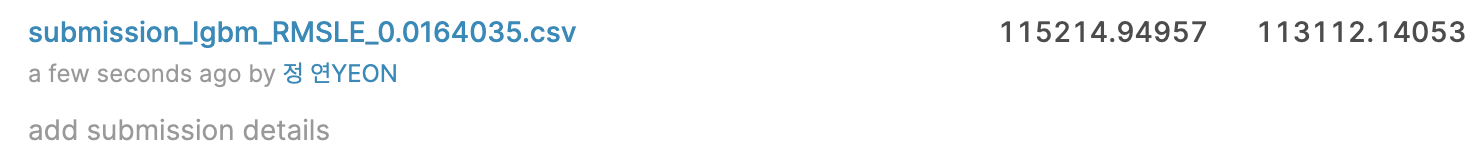

Private Score이 11000점 이하가 나오지 않아 하이퍼 파라미터를 변경해보았다.

### 하이퍼 파라미터 변경

In [24]:
param_grid = {
    'max_depth': [10, 12, 20, 40, 50],
    'learning_rate': [0.001, 0.01, 0.05, 0.1],
    'n_estimators': [10, 50, 100, 150, 200],
    'num_leaves': [50, 60, 80, 100]
}

In [25]:
model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
[CV] END learning_rate=0.1, max_depth=4, n_estimators=80, num_leaves=40; total time=   0.6s
[CV] END learning_rate=0.1, max_depth=4, n_estimators=80, num_leaves=50; total time=   0.6s
[CV] END learning_rate=0.1, max_depth=4, n_estimators=100, num_leaves=40; total time=   0.5s
[CV] END learning_rate=0.1, max_depth=4, n_estimators=100, num_leaves=50; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=4, n_estimators=100, num_leaves=60; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, n_estimators=50, num_leaves=40; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, n_estimators=50, num_leaves=40; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, n_estimators=50, num_leaves=50; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, n_estimators=50, num_leaves=60; total time=   0.5s
[CV] END learning_rate=0.1, max_depth=5, n_estimators=60, num_leaves=50; total time=   0.6s
[CV] END lear

[CV] END learning_rate=0.1, max_depth=5, n_estimators=50, num_leaves=40; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, n_estimators=50, num_leaves=50; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, n_estimators=50, num_leaves=60; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, n_estimators=50, num_leaves=60; total time=   0.5s
[CV] END learning_rate=0.1, max_depth=5, n_estimators=60, num_leaves=50; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, n_estimators=60, num_leaves=50; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, n_estimators=60, num_leaves=60; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, n_estimators=80, num_leaves=40; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=5, n_estimators=80, num_leaves=50; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=5, n_estimators=80, num_leaves=60; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=5, n_estimators=100, num_leaves=40; total 

[CV] END learning_rate=0.1, max_depth=6, n_estimators=80, num_leaves=40; total time=   0.5s
[CV] END learning_rate=0.1, max_depth=6, n_estimators=80, num_leaves=50; total time=   0.5s
[CV] END learning_rate=0.1, max_depth=6, n_estimators=80, num_leaves=60; total time=   0.5s
[CV] END learning_rate=0.1, max_depth=6, n_estimators=100, num_leaves=40; total time=   0.6s
[CV] END learning_rate=0.1, max_depth=6, n_estimators=100, num_leaves=50; total time=   0.9s
[CV] END learning_rate=0.1, max_depth=8, n_estimators=50, num_leaves=40; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=8, n_estimators=50, num_leaves=40; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=8, n_estimators=50, num_leaves=50; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=8, n_estimators=50, num_leaves=60; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=8, n_estimators=50, num_leaves=60; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=8, n_estimators=60, num_leaves=40; total

[CV] END learning_rate=0.001, max_depth=12, n_estimators=100, num_leaves=50; total time=   0.8s
[CV] END learning_rate=0.001, max_depth=12, n_estimators=100, num_leaves=60; total time=   0.9s
[CV] END learning_rate=0.001, max_depth=12, n_estimators=100, num_leaves=80; total time=   1.8s
[CV] END learning_rate=0.001, max_depth=12, n_estimators=100, num_leaves=100; total time=   2.3s
[CV] END learning_rate=0.001, max_depth=12, n_estimators=150, num_leaves=60; total time=   1.8s
[CV] END learning_rate=0.001, max_depth=12, n_estimators=150, num_leaves=80; total time=   1.7s
[CV] END learning_rate=0.001, max_depth=12, n_estimators=150, num_leaves=100; total time=   1.9s
[CV] END learning_rate=0.001, max_depth=12, n_estimators=150, num_leaves=100; total time=   3.0s
[CV] END learning_rate=0.001, max_depth=12, n_estimators=200, num_leaves=60; total time=   1.7s
[CV] END learning_rate=0.001, max_depth=12, n_estimators=200, num_leaves=80; total time=   4.1s
[CV] END learning_rate=0.001, max_dep

[CV] END learning_rate=0.001, max_depth=20, n_estimators=200, num_leaves=80; total time=   3.0s
[CV] END learning_rate=0.001, max_depth=20, n_estimators=200, num_leaves=100; total time=   3.3s
[CV] END learning_rate=0.001, max_depth=40, n_estimators=50, num_leaves=80; total time=   0.5s
[CV] END learning_rate=0.001, max_depth=40, n_estimators=50, num_leaves=80; total time=   0.5s
[CV] END learning_rate=0.001, max_depth=40, n_estimators=50, num_leaves=100; total time=   0.6s
[CV] END learning_rate=0.001, max_depth=40, n_estimators=100, num_leaves=50; total time=   0.8s
[CV] END learning_rate=0.001, max_depth=40, n_estimators=100, num_leaves=60; total time=   0.8s
[CV] END learning_rate=0.001, max_depth=40, n_estimators=100, num_leaves=80; total time=   1.0s
[CV] END learning_rate=0.001, max_depth=40, n_estimators=100, num_leaves=80; total time=   1.7s
[CV] END learning_rate=0.001, max_depth=40, n_estimators=100, num_leaves=100; total time=   1.9s
[CV] END learning_rate=0.001, max_depth=

[CV] END learning_rate=0.001, max_depth=40, n_estimators=150, num_leaves=50; total time=   1.2s
[CV] END learning_rate=0.001, max_depth=40, n_estimators=150, num_leaves=60; total time=   1.8s
[CV] END learning_rate=0.001, max_depth=40, n_estimators=150, num_leaves=80; total time=   1.8s
[CV] END learning_rate=0.001, max_depth=40, n_estimators=150, num_leaves=100; total time=   2.0s
[CV] END learning_rate=0.001, max_depth=40, n_estimators=200, num_leaves=50; total time=   1.5s
[CV] END learning_rate=0.001, max_depth=40, n_estimators=200, num_leaves=60; total time=   1.8s
[CV] END learning_rate=0.001, max_depth=40, n_estimators=200, num_leaves=80; total time=   2.5s
[CV] END learning_rate=0.001, max_depth=40, n_estimators=200, num_leaves=100; total time=   2.4s
[CV] END learning_rate=0.001, max_depth=40, n_estimators=200, num_leaves=100; total time=   2.6s
[CV] END learning_rate=0.001, max_depth=50, n_estimators=50, num_leaves=50; total time=   0.5s
[CV] END learning_rate=0.001, max_dept

[CV] END learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=80; total time=   2.1s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=100; total time=   3.8s
[CV] END learning_rate=0.01, max_depth=12, n_estimators=10, num_leaves=100; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=12, n_estimators=50, num_leaves=50; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=12, n_estimators=50, num_leaves=60; total time=   1.0s
[CV] END learning_rate=0.01, max_depth=12, n_estimators=50, num_leaves=80; total time=   0.8s
[CV] END learning_rate=0.01, max_depth=12, n_estimators=50, num_leaves=100; total time=   0.6s
[CV] END learning_rate=0.01, max_depth=12, n_estimators=100, num_leaves=50; total time=   0.9s
[CV] END learning_rate=0.01, max_depth=12, n_estimators=100, num_leaves=60; total time=   0.9s
[CV] END learning_rate=0.01, max_depth=12, n_estimators=100, num_leaves=80; total time=   1.0s
[CV] END learning_rate=0.01, max_depth=12, n_estimat

[CV] END learning_rate=0.01, max_depth=12, n_estimators=200, num_leaves=80; total time=   2.1s
[CV] END learning_rate=0.01, max_depth=12, n_estimators=200, num_leaves=100; total time=   2.9s
[CV] END learning_rate=0.01, max_depth=20, n_estimators=10, num_leaves=50; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=20, n_estimators=10, num_leaves=60; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=20, n_estimators=10, num_leaves=80; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=20, n_estimators=10, num_leaves=80; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=20, n_estimators=10, num_leaves=100; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=20, n_estimators=10, num_leaves=100; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=20, n_estimators=50, num_leaves=50; total time=   0.5s
[CV] END learning_rate=0.01, max_depth=20, n_estimators=50, num_leaves=60; total time=   0.6s
[CV] END learning_rate=0.01, max_depth=20, n_estimators

[CV] END learning_rate=0.01, max_depth=50, n_estimators=200, num_leaves=50; total time=   3.0s
[CV] END learning_rate=0.01, max_depth=50, n_estimators=200, num_leaves=80; total time=   3.4s
[CV] END learning_rate=0.01, max_depth=50, n_estimators=200, num_leaves=100; total time=   2.8s
[CV] END learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=50; total time=   0.1s
[CV] END learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=50; total time=   0.3s
[CV] END learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=60; total time=   0.3s
[CV] END learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=60; total time=   0.3s
[CV] END learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=80; total time=   0.3s
[CV] END learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=100; total time=   0.4s
[CV] END learning_rate=0.05, max_depth=10, n_estimators=50, num_leaves=50; total time=   0.9s
[CV] END learning_rate=0.05, max_depth=10, n_estimators

[CV] END learning_rate=0.05, max_depth=12, n_estimators=10, num_leaves=60; total time=   0.1s
[CV] END learning_rate=0.05, max_depth=12, n_estimators=10, num_leaves=60; total time=   0.2s
[CV] END learning_rate=0.05, max_depth=12, n_estimators=10, num_leaves=80; total time=   0.2s
[CV] END learning_rate=0.05, max_depth=12, n_estimators=10, num_leaves=80; total time=   0.2s
[CV] END learning_rate=0.05, max_depth=12, n_estimators=10, num_leaves=100; total time=   0.2s
[CV] END learning_rate=0.05, max_depth=12, n_estimators=50, num_leaves=50; total time=   0.4s
[CV] END learning_rate=0.05, max_depth=12, n_estimators=50, num_leaves=60; total time=   0.5s
[CV] END learning_rate=0.05, max_depth=12, n_estimators=50, num_leaves=60; total time=   0.5s
[CV] END learning_rate=0.05, max_depth=12, n_estimators=50, num_leaves=80; total time=   0.5s
[CV] END learning_rate=0.05, max_depth=12, n_estimators=50, num_leaves=100; total time=   0.6s
[CV] END learning_rate=0.05, max_depth=12, n_estimators=10

[CV] END learning_rate=0.05, max_depth=20, n_estimators=150, num_leaves=80; total time=   1.5s
[CV] END learning_rate=0.05, max_depth=20, n_estimators=150, num_leaves=100; total time=   1.7s
[CV] END learning_rate=0.05, max_depth=20, n_estimators=150, num_leaves=100; total time=   2.0s
[CV] END learning_rate=0.05, max_depth=20, n_estimators=200, num_leaves=50; total time=   1.4s
[CV] END learning_rate=0.05, max_depth=20, n_estimators=200, num_leaves=60; total time=   1.6s
[CV] END learning_rate=0.05, max_depth=20, n_estimators=200, num_leaves=80; total time=   1.9s
[CV] END learning_rate=0.05, max_depth=20, n_estimators=200, num_leaves=100; total time=   2.8s
[CV] END learning_rate=0.05, max_depth=40, n_estimators=10, num_leaves=60; total time=   0.1s
[CV] END learning_rate=0.05, max_depth=40, n_estimators=10, num_leaves=60; total time=   0.2s
[CV] END learning_rate=0.05, max_depth=40, n_estimators=10, num_leaves=80; total time=   0.2s
[CV] END learning_rate=0.05, max_depth=40, n_estim

[CV] END learning_rate=0.1, max_depth=10, n_estimators=10, num_leaves=50; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=10, num_leaves=50; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=10, num_leaves=50; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=10, num_leaves=50; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=10, num_leaves=50; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=10, num_leaves=60; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=10, num_leaves=60; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=10, num_leaves=80; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=50, num_leaves=50; total time=   0.6s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=50, num_leaves=60; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=50, num_leaves=

learning_rate  max_depth  n_estimators  num_leaves     score     RMSLE
336          0.100         12           200          50 -0.026437  0.162594
332          0.100         12           150          50 -0.026466  0.162685
316          0.100         10           200          50 -0.026469  0.162693
277          0.050         40           200          60 -0.026501  0.162791
297          0.050         50           200          60 -0.026501  0.162791
..             ...        ...           ...         ...       ...       ...
80           0.001         50            10          50 -0.274164  0.523607
20           0.001         12            10          50 -0.274164  0.523607
40           0.001         20            10          50 -0.274164  0.523607
60           0.001         40            10          50 -0.274164  0.523607
0            0.001         10            10          50 -0.274164  0.523607

[400 rows x 6 columns]

##### 🐬RMSLE: 0.162594
- RMSLE가 조금 낮아졌다. better !! <br/>
제일 좋은 조합은 <br/>
learning_rate=0.1, max_depth=12, n_estimators=200, num_leaves=50일 때구나! <br/>

In [26]:
model = LGBMRegressor(max_depth=12,
                      learning_rate=0.1,
                      n_estimators=200,
                      num_leaves=50,
                      random_state=random_state)

In [27]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.162594')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.162594.csv saved!


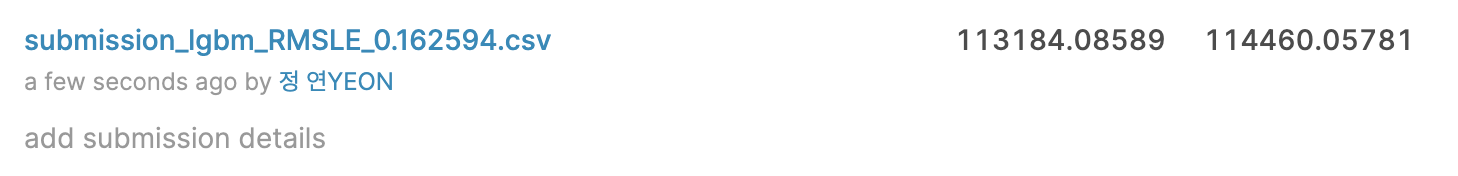

115124에서 113184로 약 2000점 감소하였지만 여전히 부족함을 느꼈다. <br/>
계속해서 하이퍼파라미터를 변경해보았다.

### 하이퍼 파라미터 변경

In [28]:
param_grid = {
    'max_depth': [10, 12, 14, 16, 20],
    'learning_rate': [0.01, 0.02, 0.1], # learning rate를 세부적으로 조정했다.
    'n_estimators': [100, 200, 300, 400], # estimators의 크기를 키워봄
    'num_leaves': [50, 60, 80, 100]
}

In [29]:
model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
[CV] END learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=60; total time=   0.7s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=80; total time=   0.8s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=80; total time=   0.8s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=100; total time=   0.9s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=150, num_leaves=50; total time=   1.0s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=150, num_leaves=60; total time=   1.6s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=150, num_leaves=80; total time=   1.2s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=150, num_leaves=100; total time=   1.3s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=50; total time=   2.3s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=60; total time=  

[CV] END learning_rate=0.1, max_depth=12, n_estimators=200, num_leaves=80; total time=   2.9s
[CV] END learning_rate=0.1, max_depth=20, n_estimators=10, num_leaves=50; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=20, n_estimators=10, num_leaves=50; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=20, n_estimators=10, num_leaves=60; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=20, n_estimators=10, num_leaves=60; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=20, n_estimators=10, num_leaves=80; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=20, n_estimators=10, num_leaves=100; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=20, n_estimators=10, num_leaves=100; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=20, n_estimators=50, num_leaves=50; total time=   0.7s
[CV] END learning_rate=0.1, max_depth=20, n_estimators=50, num_leaves=60; total time=   0.6s
[CV] END learning_rate=0.1, max_depth=20, n_estimators=50, num_leav

[CV] END learning_rate=0.1, max_depth=40, n_estimators=200, num_leaves=80; total time=   1.9s
[CV] END learning_rate=0.1, max_depth=40, n_estimators=200, num_leaves=100; total time=   2.1s
[CV] END learning_rate=0.1, max_depth=50, n_estimators=10, num_leaves=50; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=50, n_estimators=10, num_leaves=60; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=50, n_estimators=10, num_leaves=60; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=50, n_estimators=10, num_leaves=80; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=50, n_estimators=10, num_leaves=80; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=50, n_estimators=10, num_leaves=100; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=50, n_estimators=50, num_leaves=50; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=50, n_estimators=50, num_leaves=60; total time=   0.5s
[CV] END learning_rate=0.1, max_depth=50, n_estimators=50, num_lea

[CV] END learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=50; total time=   1.6s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=60; total time=   1.7s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=100; total time=   1.2s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=50; total time=   1.5s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=60; total time=   1.9s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=80; total time=   2.8s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=100; total time=   2.7s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=300, num_leaves=50; total time=   3.1s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=300, num_leaves=60; total time=   3.0s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=300, num_leaves=80; total time=   3.2s
[CV] END learning_rate=0.01, max_depth=10, n_est

[CV] END learning_rate=0.01, max_depth=16, n_estimators=200, num_leaves=100; total time=   3.0s
[CV] END learning_rate=0.01, max_depth=16, n_estimators=300, num_leaves=50; total time=   2.3s
[CV] END learning_rate=0.01, max_depth=16, n_estimators=300, num_leaves=60; total time=   2.6s
[CV] END learning_rate=0.01, max_depth=16, n_estimators=300, num_leaves=80; total time=   3.9s
[CV] END learning_rate=0.01, max_depth=16, n_estimators=300, num_leaves=100; total time=   4.1s
[CV] END learning_rate=0.01, max_depth=16, n_estimators=400, num_leaves=50; total time=   4.7s
[CV] END learning_rate=0.01, max_depth=16, n_estimators=400, num_leaves=60; total time=   4.5s
[CV] END learning_rate=0.01, max_depth=16, n_estimators=400, num_leaves=80; total time=   5.1s
[CV] END learning_rate=0.01, max_depth=16, n_estimators=400, num_leaves=100; total time=   4.9s
[CV] END learning_rate=0.01, max_depth=20, n_estimators=100, num_leaves=50; total time=   1.4s
[CV] END learning_rate=0.01, max_depth=20, n_es

[CV] END learning_rate=0.02, max_depth=10, n_estimators=200, num_leaves=50; total time=   2.2s
[CV] END learning_rate=0.02, max_depth=10, n_estimators=200, num_leaves=60; total time=   1.8s
[CV] END learning_rate=0.02, max_depth=10, n_estimators=200, num_leaves=80; total time=   2.0s
[CV] END learning_rate=0.02, max_depth=10, n_estimators=200, num_leaves=100; total time=   2.2s
[CV] END learning_rate=0.02, max_depth=10, n_estimators=300, num_leaves=50; total time=   4.2s
[CV] END learning_rate=0.02, max_depth=10, n_estimators=300, num_leaves=60; total time=   3.4s
[CV] END learning_rate=0.02, max_depth=10, n_estimators=300, num_leaves=80; total time=   4.4s
[CV] END learning_rate=0.02, max_depth=10, n_estimators=300, num_leaves=100; total time=   5.0s
[CV] END learning_rate=0.02, max_depth=10, n_estimators=400, num_leaves=60; total time=   5.3s
[CV] END learning_rate=0.02, max_depth=10, n_estimators=400, num_leaves=80; total time=   3.4s
[CV] END learning_rate=0.02, max_depth=10, n_est

[CV] END learning_rate=0.02, max_depth=12, n_estimators=300, num_leaves=80; total time=   4.0s
[CV] END learning_rate=0.02, max_depth=12, n_estimators=300, num_leaves=100; total time=   3.3s
[CV] END learning_rate=0.02, max_depth=12, n_estimators=400, num_leaves=50; total time=   3.9s
[CV] END learning_rate=0.02, max_depth=12, n_estimators=400, num_leaves=60; total time=   3.1s
[CV] END learning_rate=0.02, max_depth=12, n_estimators=400, num_leaves=80; total time=   5.2s
[CV] END learning_rate=0.02, max_depth=12, n_estimators=400, num_leaves=100; total time=   5.5s
[CV] END learning_rate=0.02, max_depth=14, n_estimators=100, num_leaves=60; total time=   1.3s
[CV] END learning_rate=0.02, max_depth=14, n_estimators=100, num_leaves=80; total time=   2.0s
[CV] END learning_rate=0.02, max_depth=14, n_estimators=100, num_leaves=100; total time=   1.4s
[CV] END learning_rate=0.02, max_depth=14, n_estimators=200, num_leaves=50; total time=   2.1s
[CV] END learning_rate=0.02, max_depth=14, n_es

learning_rate  max_depth  n_estimators  num_leaves     score     RMSLE
180           0.10         12           200          50 -0.026437  0.162594
164           0.10         10           200          50 -0.026469  0.162693
168           0.10         10           300          50 -0.026486  0.162744
196           0.10         14           200          50 -0.026505  0.162803
228           0.10         20           200          50 -0.026517  0.162839
..             ...        ...           ...         ...       ...       ...
32            0.01         14           100          50 -0.076764  0.277064
48            0.01         16           100          50 -0.076764  0.277064
64            0.01         20           100          50 -0.076764  0.277064
16            0.01         12           100          50 -0.076764  0.277064
0             0.01         10           100          50 -0.076779  0.277090

[240 rows x 6 columns]

범위를 변경해봐도 최적의 하이퍼파라미터가 동일하게 나왔다. 이번 단계에서 변경한 파라미터 값들은 무용지물임을 깨달았다.

### 하이퍼파라미터 변경

In [30]:
# 굉장히 오래걸림 ****
param_grid = {
    'max_depth': [20, 50, 70, 100],
    'learning_rate': [0.001, 0.01, 0.1], # 다시 원래대로
    'n_estimators': [100, 150, 200, 400],
    'num_leaves': [20, 50, 70]
}

In [31]:
model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV] END learning_rate=0.02, max_depth=20, n_estimators=300, num_leaves=80; total time=   3.1s
[CV] END learning_rate=0.02, max_depth=20, n_estimators=300, num_leaves=100; total time=   6.3s
[CV] END learning_rate=0.02, max_depth=20, n_estimators=400, num_leaves=60; total time=   3.9s
[CV] END learning_rate=0.02, max_depth=20, n_estimators=400, num_leaves=60; total time=   6.2s
[CV] END learning_rate=0.02, max_depth=20, n_estimators=400, num_leaves=100; total time=   5.9s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=50; total time=   0.7s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=60; total time=   0.7s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=60; total time=   0.8s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=80; total time=   0.9s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=80; total tim

[CV] END learning_rate=0.1, max_depth=10, n_estimators=400, num_leaves=80; total time=   3.5s
[CV] END learning_rate=0.1, max_depth=10, n_estimators=400, num_leaves=100; total time=   3.9s
[CV] END learning_rate=0.1, max_depth=12, n_estimators=100, num_leaves=50; total time=   0.9s
[CV] END learning_rate=0.1, max_depth=12, n_estimators=100, num_leaves=60; total time=   0.8s
[CV] END learning_rate=0.1, max_depth=12, n_estimators=100, num_leaves=80; total time=   0.9s
[CV] END learning_rate=0.1, max_depth=12, n_estimators=100, num_leaves=100; total time=   1.2s
[CV] END learning_rate=0.1, max_depth=12, n_estimators=200, num_leaves=50; total time=   1.8s
[CV] END learning_rate=0.1, max_depth=12, n_estimators=200, num_leaves=60; total time=   2.1s
[CV] END learning_rate=0.1, max_depth=12, n_estimators=200, num_leaves=80; total time=   1.7s
[CV] END learning_rate=0.1, max_depth=12, n_estimators=200, num_leaves=100; total time=   2.5s
[CV] END learning_rate=0.1, max_depth=12, n_estimators=30

[CV] END learning_rate=0.1, max_depth=16, n_estimators=400, num_leaves=50; total time=   3.2s
[CV] END learning_rate=0.1, max_depth=16, n_estimators=400, num_leaves=60; total time=   3.9s
[CV] END learning_rate=0.1, max_depth=16, n_estimators=400, num_leaves=80; total time=   4.5s
[CV] END learning_rate=0.1, max_depth=16, n_estimators=400, num_leaves=100; total time=   3.6s
[CV] END learning_rate=0.1, max_depth=20, n_estimators=100, num_leaves=60; total time=   1.1s
[CV] END learning_rate=0.1, max_depth=20, n_estimators=100, num_leaves=80; total time=   0.9s
[CV] END learning_rate=0.1, max_depth=20, n_estimators=100, num_leaves=100; total time=   1.1s
[CV] END learning_rate=0.1, max_depth=20, n_estimators=200, num_leaves=50; total time=   1.2s
[CV] END learning_rate=0.1, max_depth=20, n_estimators=200, num_leaves=60; total time=   2.3s
[CV] END learning_rate=0.1, max_depth=20, n_estimators=200, num_leaves=80; total time=   3.6s
[CV] END learning_rate=0.1, max_depth=20, n_estimators=300

[CV] END learning_rate=0.001, max_depth=20, n_estimators=400, num_leaves=70; total time=   5.2s
[CV] END learning_rate=0.001, max_depth=50, n_estimators=100, num_leaves=50; total time=   1.1s
[CV] END learning_rate=0.001, max_depth=50, n_estimators=100, num_leaves=70; total time=   1.5s
[CV] END learning_rate=0.001, max_depth=50, n_estimators=150, num_leaves=20; total time=   1.5s
[CV] END learning_rate=0.001, max_depth=50, n_estimators=150, num_leaves=50; total time=   2.1s
[CV] END learning_rate=0.001, max_depth=50, n_estimators=200, num_leaves=20; total time=   1.0s
[CV] END learning_rate=0.001, max_depth=50, n_estimators=200, num_leaves=20; total time=   1.6s
[CV] END learning_rate=0.001, max_depth=50, n_estimators=200, num_leaves=70; total time=   2.3s
[CV] END learning_rate=0.001, max_depth=50, n_estimators=400, num_leaves=20; total time=   1.8s
[CV] END learning_rate=0.001, max_depth=50, n_estimators=400, num_leaves=20; total time=   2.9s
[CV] END learning_rate=0.001, max_depth=

[CV] END learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=70; total time=   0.9s[CV] END learning_rate=0.001, max_depth=100, n_estimators=150, num_leaves=50; total time=   2.5s
[CV] END learning_rate=0.001, max_depth=100, n_estimators=200, num_leaves=20; total time=   1.9s
[CV] END learning_rate=0.001, max_depth=100, n_estimators=200, num_leaves=50; total time=   1.8s
[CV] END learning_rate=0.001, max_depth=100, n_estimators=200, num_leaves=70; total time=   1.9s
[CV] END learning_rate=0.001, max_depth=100, n_estimators=400, num_leaves=20; total time=   2.2s
[CV] END learning_rate=0.001, max_depth=100, n_estimators=400, num_leaves=50; total time=   5.9s
[CV] END learning_rate=0.001, max_depth=100, n_estimators=400, num_leaves=70; total time=   5.3s
[CV] END learning_rate=0.01, max_depth=20, n_estimators=100, num_leaves=70; total time=   1.2s
[CV] END learning_rate=0.01, max_depth=20, n_estimators=150, num_leaves=20; total time=   0.7s
[CV] END learning_rate=0.01, max_depth

learning_rate  max_depth  n_estimators  num_leaves     score     RMSLE
105          0.100         20           400          20 -0.026205  0.161880
141          0.100        100           400          20 -0.026205  0.161880
117          0.100         50           400          20 -0.026205  0.161880
129          0.100         70           400          20 -0.026205  0.161880
103          0.100         20           200          50 -0.026517  0.162839
..             ...        ...           ...         ...       ...       ...
25           0.001         70           100          50 -0.238120  0.487975
36           0.001        100           100          20 -0.240782  0.490695
24           0.001         70           100          20 -0.240782  0.490695
12           0.001         50           100          20 -0.240782  0.490695
0            0.001         20           100          20 -0.240782  0.490695

[144 rows x 6 columns]

##### 🐬 RMSLE: 0.161880
제일 좋은 조합은 <br/>
learning_rate=0.1, max_depth=20, n_estimators=400, num_leaves=20일 때구나! <br/>

In [32]:
model = LGBMRegressor(max_depth=20,
                      learning_rate=0.1,
                      n_estimators=400,
                      num_leaves=20,
                      random_state=random_state)

In [33]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.161880')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.161880.csv saved!


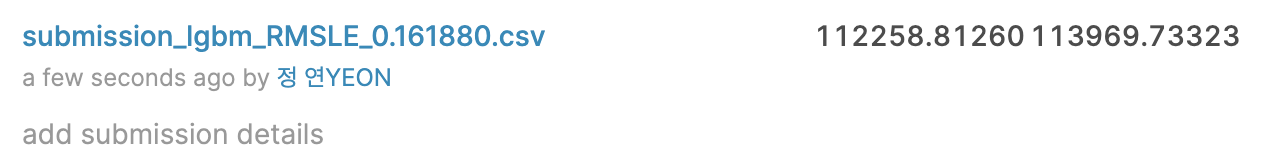

점수가 좀 더 좋아졌지만 아직 조금 부족하다. 뭐가 문제일까?!

### XGBRegressor - 하이퍼파라미터 그대로
- 이번엔 LGBMRegressor이 아닌 XGBRegressor을 이용해봤다.
- 하이퍼파라미터는 동일하게 적용하여 두 regressor 중 어떤 것이 더 좋은 성능을 내는지 살펴보자.

In [34]:
model = XGBRegressor(max_depth=12,
                      learning_rate=0.1,
                      n_estimators=200,
                      num_leaves=50,
                      random_state=random_state)

In [35]:
save_submission(model, train, y, test, 'xgboost', rmsle='0.162594')

[13:51:26] WARNING: ../src/learner.cc:573: 
Parameters: { "num_leaves" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


/aiffel/aiffel/kaggle_kakr_housing/data/submission_xgboost_RMSLE_0.162594.csv saved!


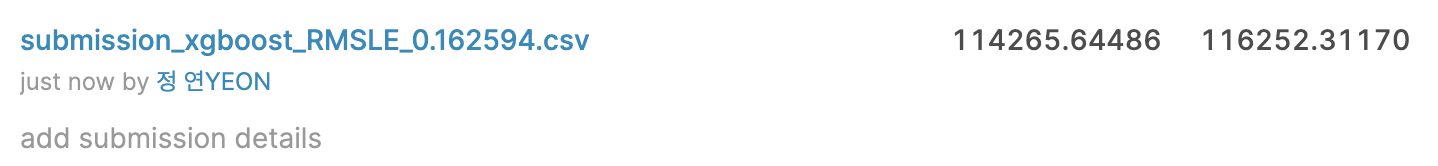

점수가 더 안 좋게 나와 XGBRegressor은 LGBM보다 성능이 좋지 않음을 깨달았다.

### RandomForestRegressor

In [36]:
# 너무 오래 걸림 흑흑
param_grid = {
    'max_depth': [4, 6, 8, 20],
    'n_estimators': [10, 50, 100, 200],
    'min_samples_leaf': [8, 12, 18],
    'min_samples_split': [8, 16, 20]
}

In [37]:
model = RandomForestRegressor(random_state=random_state, n_jobs=-5)
grid_cv = GridSearchCV(model, param_grid=param_grid, cv=2, n_jobs=-5)
grid_cv.fit(train, y)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

# my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

[CV] END learning_rate=0.1, max_depth=20, n_estimators=200, num_leaves=20; total time=   0.8s
[CV] END learning_rate=0.1, max_depth=20, n_estimators=200, num_leaves=50; total time=   1.2s
[CV] END learning_rate=0.1, max_depth=20, n_estimators=200, num_leaves=70; total time=   2.1s
[CV] END learning_rate=0.1, max_depth=20, n_estimators=400, num_leaves=20; total time=   1.5s
[CV] END learning_rate=0.1, max_depth=20, n_estimators=400, num_leaves=50; total time=   2.4s
[CV] END learning_rate=0.1, max_depth=20, n_estimators=400, num_leaves=70; total time=   5.2s
[CV] END learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=50; total time=   0.7s
[CV] END learning_rate=0.1, max_depth=50, n_estimators=100, num_leaves=70; total time=   0.8s
[CV] END learning_rate=0.1, max_depth=50, n_estimators=150, num_leaves=20; total time=   0.6s
[CV] END learning_rate=0.1, max_depth=50, n_estimators=150, num_leaves=20; total time=   0.6s
[CV] END learning_rate=0.1, max_depth=50, n_estimators=150, 

[CV] END learning_rate=0.1, max_depth=70, n_estimators=400, num_leaves=20; total time=   1.4s
[CV] END learning_rate=0.1, max_depth=70, n_estimators=400, num_leaves=50; total time=   3.7s
[CV] END learning_rate=0.1, max_depth=70, n_estimators=400, num_leaves=70; total time=   3.8s
[CV] END learning_rate=0.1, max_depth=100, n_estimators=100, num_leaves=70; total time=   0.9s
[CV] END learning_rate=0.1, max_depth=100, n_estimators=150, num_leaves=20; total time=   0.7s
[CV] END learning_rate=0.1, max_depth=100, n_estimators=150, num_leaves=20; total time=   0.7s
[CV] END learning_rate=0.1, max_depth=100, n_estimators=150, num_leaves=50; total time=   1.1s
[CV] END learning_rate=0.1, max_depth=100, n_estimators=150, num_leaves=70; total time=   2.3s
[CV] END learning_rate=0.1, max_depth=100, n_estimators=200, num_leaves=50; total time=   1.5s
[CV] END learning_rate=0.1, max_depth=100, n_estimators=200, num_leaves=70; total time=   1.6s
[CV] END learning_rate=0.1, max_depth=100, n_estimato


[CV] END learning_rate=0.1, max_depth=50, n_estimators=150, num_leaves=20; total time=   1.1s
[CV] END learning_rate=0.1, max_depth=50, n_estimators=150, num_leaves=50; total time=   1.9s
[CV] END learning_rate=0.1, max_depth=50, n_estimators=200, num_leaves=20; total time=   1.5s
[CV] END learning_rate=0.1, max_depth=50, n_estimators=200, num_leaves=50; total time=   1.9s
[CV] END learning_rate=0.1, max_depth=50, n_estimators=200, num_leaves=70; total time=   1.6s
[CV] END learning_rate=0.1, max_depth=50, n_estimators=400, num_leaves=20; total time=   1.4s
[CV] END learning_rate=0.1, max_depth=50, n_estimators=400, num_leaves=50; total time=   2.3s
[CV] END learning_rate=0.1, max_depth=50, n_estimators=400, num_leaves=70; total time=   4.2s
[CV] END learning_rate=0.1, max_depth=70, n_estimators=100, num_leaves=20; total time=   0.5s
[CV] END learning_rate=0.1, max_depth=70, n_estimators=100, num_leaves=50; total time=   0.8s
[CV] END learning_rate=0.1, max_depth=70, n_estimators=100,

이번엔 위에서 따로 만든 my_GridSearch 함수를 이용하지 않고 GridSearchCV의 best_params_, best_score_ 함수를 이용해 최적의 파라미터와 예측 정확도를 도출했다. (혹시나 시간이 단축되지 않을까 하는 생각으로 이용해보았지만 별 다른 점은 없었다.)

In [38]:
model = RandomForestRegressor(max_depth=20,
                              min_samples_leaf=8,
                              min_samples_split=8,
                              n_estimators=200,
                              random_state=random_state)

In [39]:
# rmsle 계산하는 식을 이용하지 못해 점수를 넣진 못했다.
save_submission(model, train, y, test, 'rf', rmsle='0')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_rf_RMSLE_0.csv saved!


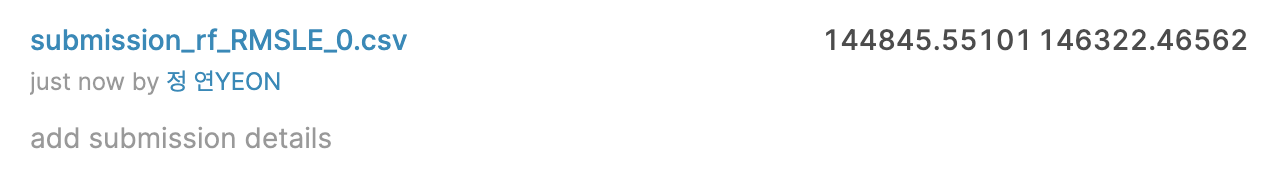

성능이 매우 안 좋다. 모델 문제일 수도 있고 하이퍼 파라미터 문제일 수도 있을 것이라 판단

## 6. 랜덤 탐색
- 위에서 수 차례 gridsearcCV를 이용해보았는데 모델링하는 속도가 너무나 오래 걸렸다. <br/><br/>
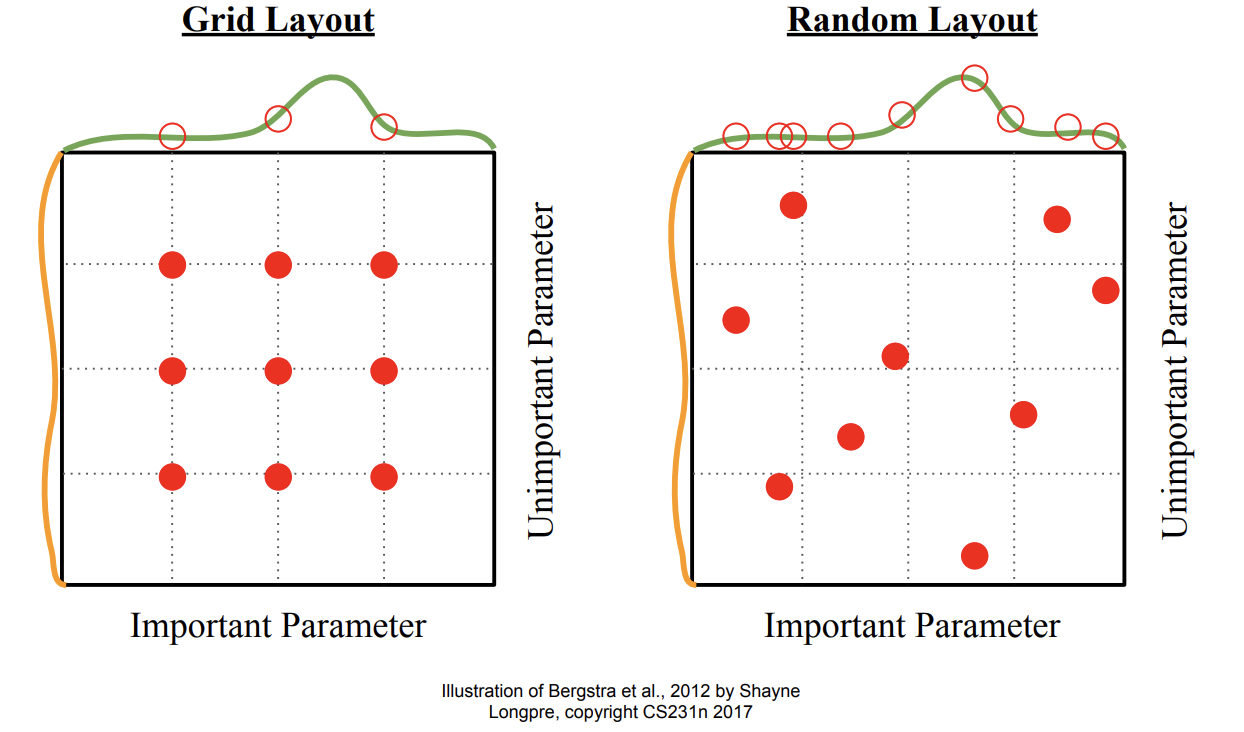
- 내 모델이 특정 파라미터의 변화에 더 민감하게 반응하고 있는 경우 grdid search는 위의 그림처럼 비효율적인 dimensionality를 보인다.
- Random Search는 중요한 파라미터에 더 많은 샘플링이 가능하므로 더 좋은 성능을 내는 경향이 있다.
- 이러한 이유로 아래부터는 grid search 대신 random search 방식을 활용했다.

In [40]:
from sklearn.model_selection import RandomizedSearchCV

#### Random Search 함수 생성
- param_grid 대신 param_distributions을 넣어줘야 한다.

In [41]:
def my_RandomSearch(model, train, y, param_distributions, verbose=2, n_jobs=5):
    
    # RandomizedSearchCV 모델로 초기화
    random_model = RandomizedSearchCV(model,
                             param_distributions=param_distributions,
                             scoring='neg_mean_squared_error',
                             cv=5,
                             verbose=verbose,
                             n_jobs=n_jobs)
    # 모델 fitting
    random_model.fit(train, y)
    
    # 결과값 저장
    params = random_model.cv_results_['params']
    score = random_model.cv_results_['mean_test_score']

    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [42]:
param_distributions = {
    'max_depth': [20, 40, 50, 60, 70, 100],
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [100, 150, 200, 400, 700, 800]
}

In [43]:
model = LGBMRegressor(random_state=random_state)
my_RandomSearch(model, train, y, param_distributions, verbose=2, n_jobs=5)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


n_estimators  max_depth  learning_rate     score     RMSLE
0           400        100          0.100 -0.026206  0.161883
5           150        100          0.100 -0.026460  0.162666
7           150         60          0.100 -0.026460  0.162666
9           700         60          0.100 -0.026517  0.162839
6           800         40          0.010 -0.027123  0.164690
1           700         50          0.010 -0.027504  0.165844
2           200         40          0.010 -0.043829  0.209353
3           150        100          0.010 -0.055811  0.236244
4           150         20          0.010 -0.055811  0.236244
8           700         20          0.001 -0.109997  0.331658

In [44]:
model = LGBMRegressor(max_depth=100,
                      learning_rate=0.1,
                      n_estimators=400,
                      random_state=random_state)

save_submission(model, train, y, test, 'lgbm_random', rmsle='0.161883')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_random_RMSLE_0.161883.csv saved!


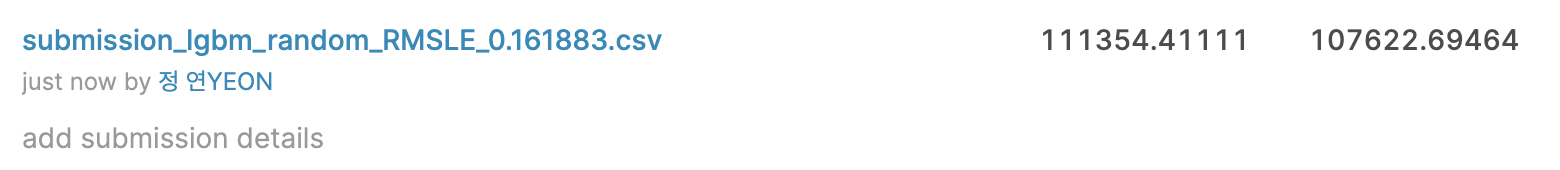

지금가지 중 가장 좋은 성능을 보였고, 모델 돌리는 시간이 굉장히 단축되었다.

### 하이퍼파라미터 튜닝

In [45]:
param_distributions = {
    'max_depth': [20, 40, 50, 60, 70, 100],
    'learning_rate': [0.001, 0.01, 0.1, 0.2],
    'n_estimators': [100, 150, 200, 300, 400, 500, 600, 700, 800]
}

In [46]:
model = LGBMRegressor(random_state=random_state)
my_RandomSearch(model, train, y, param_distributions, verbose=2, n_jobs=5)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Warning] Unknown parameter: n_leaves


n_leaves  n_estimators  max_depth  learning_rate     score     RMSLE
9        60           700         70          0.100 -0.026517  0.162839
8        10           100         50          0.100 -0.027051  0.164472
3        40           150         70          0.200 -0.027238  0.165040
6        20           200         40          0.200 -0.027466  0.165729
1        40           700         40          0.010 -0.027504  0.165844
0        60           600        100          0.200 -0.028357  0.168395
2        20           800         60          0.001 -0.098822  0.314360
4        60           800         50          0.001 -0.098822  0.314360
7        40           600         70          0.001 -0.123263  0.351088
5        10           100         20          0.001 -0.239401  0.489286

RMSLE 점수가 더 높게 나와 다시 튜닝해주었다.

### 하이퍼파라미터 튜닝

In [47]:
param_distributions = {
    'max_depth': [10, 20, 40, 50, 60, 70, 100],
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.5],
    'n_estimators': [100, 120, 150, 180, 200, 300, 400, 500, 600, 700, 800],
    'num_leaves': [1, 4, 6, 8, 10, 20, 40, 50, 60, 80]
}

model = LGBMRegressor(random_state=random_state)
my_RandomSearch(model, train, y, param_distributions, verbose=2, n_jobs=5)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


n_leaves  n_estimators  max_depth  learning_rate     score     RMSLE
1        10           700         10          0.050 -0.025881  0.160877
2        10           800         40          0.050 -0.026049  0.161397
4        40           500        100          0.100 -0.026340  0.162295
9        40           180         10          0.050 -0.027047  0.164460
7        50           100         20          0.100 -0.027051  0.164472
3        40           120         10          0.500 -0.032612  0.180587
6        60           500         20          0.500 -0.034614  0.186047
5         6           120        100          0.010 -0.068551  0.261822
0        40           100         50          0.010 -0.081080  0.284745
8        50           500         50          0.001 -0.139021  0.372855

In [59]:
model = LGBMRegressor(max_depth=10,
                      learning_rate=0.05,
                      n_estimators=700,
                      random_state=random_state)

save_submission(model, train, y, test, 'lgbm_random', rmsle='0.160877')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_random_RMSLE_0.160877.csv saved!


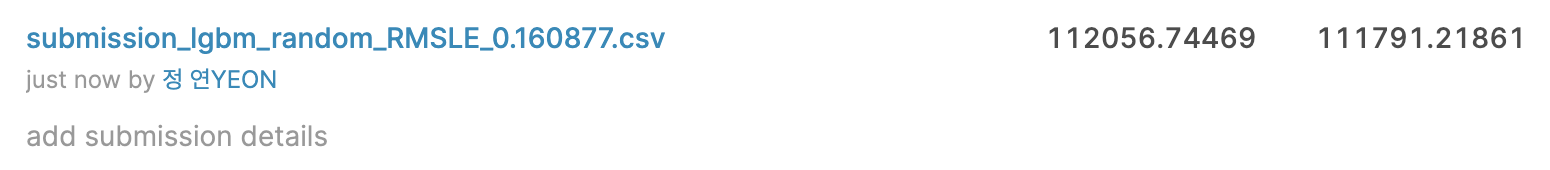

RMSLE는 지금까지 중 가장 낮았지만 점수가 그만큼 좋진 않았다. RMSE와 점수가 비례관계가 성립하는 것이 아님을 깨달았다.

### 하이퍼파라미터 튜닝

In [49]:
param_distributions = {
    'max_depth': [20, 40, 50, 60, 70, 80, 90, 100, 200],
    'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5],
    'n_estimators': [100, 120, 150, 180, 200, 350, 500, 600, 650, 700, 800],
    'num_leaves': [1, 4, 6, 8, 10, 30, 40, 60, 80, 100]
}

model = LGBMRegressor(random_state=random_state)
my_RandomSearch(model, train, y, param_distributions, verbose=2, n_jobs=5)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Warning] Unknown parameter: n_leaves


n_leaves  n_estimators  max_depth  learning_rate     score     RMSLE
3         1           800         90          0.050 -0.026049  0.161397
8         6           200         90          0.100 -0.026245  0.162003
9         6           150         40          0.100 -0.026460  0.162666
6         6           200         90          0.050 -0.026882  0.163958
4        10           120         80          0.500 -0.032669  0.180745
0        10           200        200          0.500 -0.033441  0.182870
2         6           200        200          0.010 -0.043829  0.209353
7         6           700         50          0.001 -0.109997  0.331658
5        60           500        100          0.001 -0.139021  0.372855
1         6           350         70          0.001 -0.168522  0.410514

In [64]:
model = LGBMRegressor(max_depth=90,
                      learning_rate=0.05,
                      n_estimators=800,
                      random_state=random_state)

save_submission(model, train, y, test, 'lgbm_random', rmsle='0.161397')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_random_RMSLE_0.161397.csv saved!


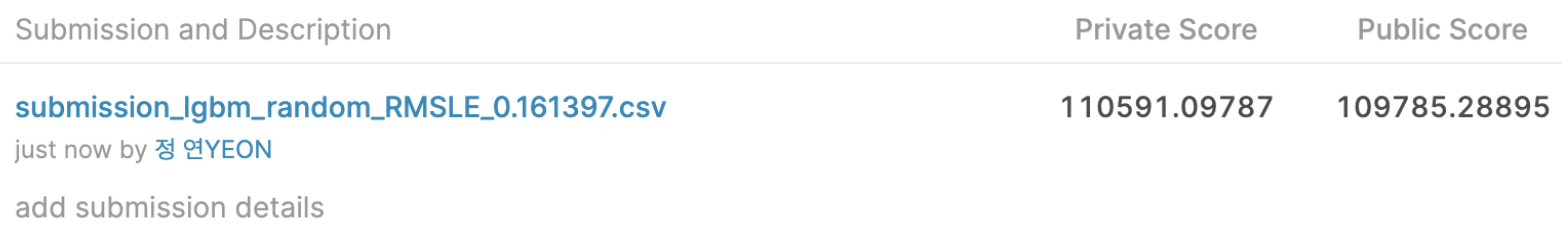

지금까지 중 가장 좋은 성능이 나왔다. 마찬가지 논리로 점수는 가장 좋았지만 그렇다고 RMSLE가 가장 낮지는 않았다.

### 하이퍼파라미터 튜닝

In [51]:
param_distributions = {
    'max_depth': [10, 12, 14, 20, 30, 40, 50, 60, 80, 100],
    'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5],
    'n_estimators': [200, 350, 500, 550, 600, 650, 700, 750, 800, 1000, 1200],
    'num_leaves': [1, 2, 3, 4, 5, 6, 8, 10, 30, 40, 50, 60, 80]
}

model = LGBMRegressor(random_state=random_state)
my_RandomSearch(model, train, y, param_distributions, verbose=2, n_jobs=5)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


num_leaves  n_estimators  max_depth  learning_rate     score     RMSLE
1           8           750         30          0.050 -0.027130  0.164711
3          50          1200         12          0.005 -0.027323  0.165297
2           5           350         40          0.500 -0.028087  0.167592
8          40           500         10          0.010 -0.028580  0.169057
5          30          1200         12          0.500 -0.035053  0.187225
6           4           800         50          0.010 -0.040672  0.201672
7          40           200         12          0.010 -0.042275  0.205610
9          30          1000         80          0.001 -0.081703  0.285838
0          50           800         12          0.001 -0.094574  0.307529
4           2          1200         12          0.001 -0.153606  0.391925

아무리 정비례 관계는 아니다하더라도 RMSLE가 너무 높게 나와 제출하지 않았다.

### 하이퍼파라미터 튜닝

In [53]:
param_distributions = {
    'max_depth': [10, 12, 14, 20, 30, 40, 50, 60, 80, 100],
    'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5],
    'n_estimators': [200, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000],
    'num_leaves': [1, 2, 3, 4, 5, 10, 32, 40, 50, 64, 128]
}

model = LGBMRegressor(random_state=random_state)
my_RandomSearch(model, train, y, param_distributions, verbose=2, n_jobs=5)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .



num_leaves  n_estimators  max_depth  learning_rate     score     RMSLE
8          10           600         50          0.100 -0.026298  0.162166
4          40           700         12          0.010 -0.027286  0.165184
0          50           950         10          0.005 -0.028279  0.168163
5           5           700         14          0.500 -0.029104  0.170600
3          10           850         12          0.500 -0.033180  0.182154
6           5           800         14          0.010 -0.036758  0.191723
1           4           200         40          0.050 -0.038027  0.195006
7          40           950         10          0.001 -0.082833  0.287807
9          40           750         20          0.001 -0.101863  0.319160
2           1           850         14          0.005       NaN       NaN

In [67]:
model = LGBMRegressor(max_depth=50,
                      learning_rate=0.100,
                      n_estimators=600,
                      num_leaves=10,
                      random_state=random_state)

save_submission(model, train, y, test, 'lgbm_random', rmsle='0.162166')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_random_RMSLE_0.162166.csv saved!


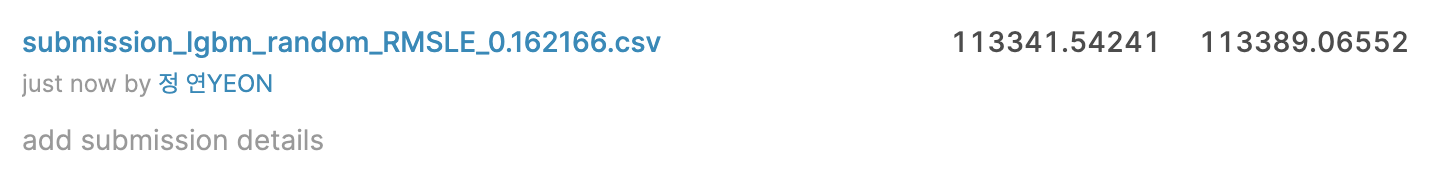

### 하이퍼 파라미터 조정

In [71]:
param_distributions = {
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 20, 40, 50, 60, 70, 80, 90, 100, 200],
    'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5],
    'n_estimators': [100, 200, 400, 600, 800, 1000, 1200, 1500, 1800, 2000, 3000, 4000]
}

model = LGBMRegressor(random_state=random_state)
my_RandomSearch(model, train, y, param_distributions, verbose=2, n_jobs=5)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


n_estimators  max_depth  learning_rate     score     RMSLE
7          1000          8          0.050 -0.026016  0.161296
3          2000        200          0.100 -0.027303  0.165237
4          1500          5          0.010 -0.027454  0.165694
5          1200        200          0.005 -0.028059  0.167507
9          1000          7          0.005 -0.029483  0.171707
8          1000          6          0.005 -0.030019  0.173260
2           100          4          0.100 -0.030218  0.173835
0           800         20          0.005 -0.030669  0.175125
6          1200          4          0.500 -0.033299  0.182479
1           200         10          0.005 -0.081263  0.285068

In [72]:
model = LGBMRegressor(max_depth=8,
                      learning_rate=0.050,
                      n_estimators=1000,
                      random_state=random_state)

save_submission(model, train, y, test, 'lgbm_random', rmsle='0.161296')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_random_RMSLE_0.161296.csv saved!


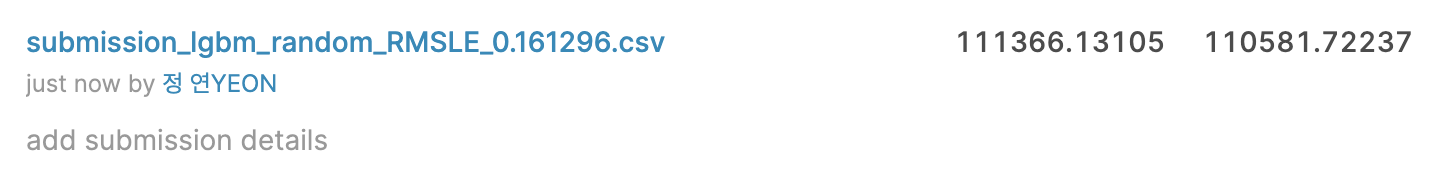

### 하이퍼파라미터 튜닝

In [76]:
param_distributions = {
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 20],
    'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5],
    'n_estimators': [800, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1800, 2000]
}

model = LGBMRegressor(random_state=random_state)
my_RandomSearch(model, train, y, param_distributions, verbose=2, n_jobs=5)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


n_estimators  max_depth  learning_rate     score     RMSLE
9           800          7          0.050 -0.025888  0.160897
7          1000          8          0.050 -0.026016  0.161296
3          2000          5          0.050 -0.026485  0.162743
2          1000         20          0.010 -0.026690  0.163371
0          1300          6          0.005 -0.028800  0.169705
6          1200          3          0.500 -0.031089  0.176321
4          1000          4          0.500 -0.032987  0.181624
5          1300          8          0.500 -0.035382  0.188102
1          1400         20          0.001 -0.059635  0.244203
8          1400          5          0.001 -0.062579  0.250158

In [77]:
model = LGBMRegressor(max_depth=7,
                      learning_rate=0.050,
                      n_estimators=800,
                      random_state=random_state)

save_submission(model, train, y, test, 'lgbm_random', rmsle='0.160897')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_random_RMSLE_0.160897.csv saved!
[CV] END ..learning_rate=0.01, max_depth=6, n_estimators=100; total time=   0.6s
[CV] END .learning_rate=0.01, max_depth=5, n_estimators=1800; total time=   8.2s
[CV] END ..learning_rate=0.1, max_depth=8, n_estimators=1000; total time=   5.5s
[CV] END ..learning_rate=0.05, max_depth=7, n_estimators=200; total time=   2.0s
[CV] END ..learning_rate=0.1, max_depth=8, n_estimators=2000; total time=   9.2s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=800; total time=   2.1s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=800; total time=   1.6s
[CV] END ..learning_rate=0.1, max_depth=7, n_estimators=2000; total time=   8.2s
[CV] END .learning_rate=0.001, max_depth=5, n_estimators=100; total time=   0.9s
[CV] END .learning_rate=0.001, max_depth=5, n_estimators=100; total time=   0.7s
[CV] END .learning_rate=0.01, max_depth=9, n_estimators=1200; total time=   6.3s
[CV] END learning_ra

[CV] END ..learning_rate=0.01, max_depth=6, n_estimators=100; total time=   0.6s
[CV] END .learning_rate=0.01, max_depth=5, n_estimators=1800; total time=   6.7s
[CV] END ..learning_rate=0.1, max_depth=8, n_estimators=1000; total time=   5.5s
[CV] END ..learning_rate=0.1, max_depth=8, n_estimators=1000; total time=   4.8s
[CV] END ..learning_rate=0.1, max_depth=8, n_estimators=2000; total time=   8.3s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=800; total time=   1.8s
[CV] END ..learning_rate=0.1, max_depth=7, n_estimators=2000; total time=  11.5s
[CV] END .learning_rate=0.01, max_depth=9, n_estimators=1200; total time=   6.2s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=1200; total time=   7.3s
[CV] END learning_rate=0.005, max_depth=20, n_estimators=800; total time=   5.6s
[CV] END learning_rate=0.005, max_depth=10, n_estimators=200; total time=   1.3s
[CV] END learning_rate=0.005, max_depth=10, n_estimators=200; total time=   1.3s
[CV] END learning_rate=0.1, 

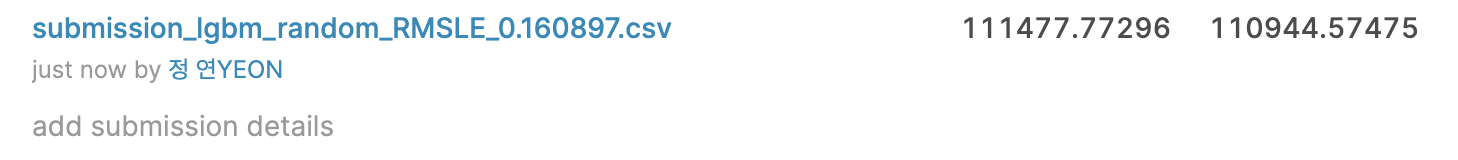

### 하이퍼파라미터 튜닝 - num_leaves 추가

In [79]:
param_distributions = {
    'max_depth': [1, 2, 3, 4, 5, 6, 8, 10],
    'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1],
    'n_estimators': [800, 1000, 1100, 1200, 1400, 1500, 2000],
    'num_leaves': [1, 2, 3, 4, 6, 8, 10] # 추가
}

model = LGBMRegressor(random_state=random_state)
my_RandomSearch(model, train, y, param_distributions, verbose=2, n_jobs=5)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .



num_leaves  n_estimators  max_depth  learning_rate     score     RMSLE
5          10          1000          4          0.100 -0.026146  0.161698
2           6           800          4          0.050 -0.027731  0.166525
3           8          1200          6          0.010 -0.030202  0.173787
9          10          1500          3          0.005 -0.035453  0.188289
1           6          1100          6          0.005 -0.039081  0.197689
8           4          1000          6          0.005 -0.048034  0.219167
0          10          1400          3          0.001 -0.080607  0.283914
7           6          1100          8          0.001 -0.101886  0.319197
4           6           800          3          0.001 -0.125084  0.353673
6           1          1500          6          0.005       NaN       NaN

In [80]:
model = LGBMRegressor(max_depth=10,
                      learning_rate=0.100,
                      n_estimators=1000,
                      num_leavevs=10,
                      random_state=random_state)

save_submission(model, train, y, test, 'lgbm_random', rmsle='0.161698')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_random_RMSLE_0.161698.csv saved!


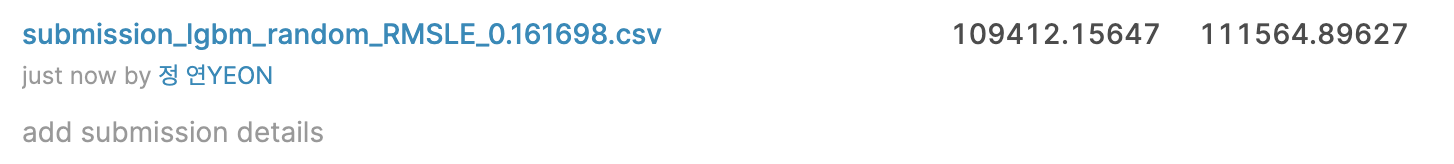

### 🐬드디어 점수가 11000이하로 나왔다

******

# 🧤 회고

### 👍 하이퍼 파라미터별 성능 비교

In [82]:
df = pd.DataFrame(data={'Name': ['lightgbm', 'lightgbm', 'lightgbm', 'xgboost', 'randomforest', 'lightgbm', 'lightgbm', 'lightgbm', 'lightgbm', 'lightgbm', 'lightgbm', 'lightgbm'],
                        'Search': ['GridSearch', 'GridSearch', 'GridSearch', 'GridSearch', 'GridSearch', 'RandomSearch', 'RandomSearch', 'RandomSearch', 'RandomSearch', 'RandomSearch', 'RandomSearch', 'RandomSearch'],
                        'max_depth': [10, 12, 20, 12, 20, 100, 90, 10, 50, 8, 7, 10],
                        'learning_rate': [0.1, 0.1, 0.1, 0.1, 'x', 0.1, 0.05, 0.05, 0.1, 0.05, 0.05, 0.1],
                        'n_estimators': [100, 200, 400, 200, 200, 400, 800, 700, 600, 1000, 800, 1000],
                        'num_leaves': [60, 50, 20, 50, 'x', 'x', 'x', 'x', 10, 'x', 'x', 10],
                        'rmsle': [0.164035, 0.162594, 0.161880, 0.162594, 'x', 0.161883, 0.161397, 0.160877, 0.162166, 0.161296, 0.160897, 0.161698],
                        'Private Score': [115214, 113184, 112258, 114265, 144845, 111354, 110591, 112056, 113341, 111366, 111477, 109412],
                        'Public Score': [113112, 114460, 113696, 116252, 146322, 107622, 109785, 111791, 113389, 110581, 110944, 111564]})
df = df.sort_values(by=['Private Score'], ascending=True)
df                      

Name        Search  max_depth learning_rate  n_estimators  \
11      lightgbm  RandomSearch         10           0.1          1000   
6       lightgbm  RandomSearch         90          0.05           800   
5       lightgbm  RandomSearch        100           0.1           400   
9       lightgbm  RandomSearch          8          0.05          1000   
10      lightgbm  RandomSearch          7          0.05           800   
7       lightgbm  RandomSearch         10          0.05           700   
2       lightgbm    GridSearch         20           0.1           400   
1       lightgbm    GridSearch         12           0.1           200   
8       lightgbm  RandomSearch         50           0.1           600   
3        xgboost    GridSearch         12           0.1           200   
0       lightgbm    GridSearch         10           0.1           100   
4   randomforest    GridSearch         20             x           200   

   num_leaves     rmsle  Private Score  Public Score  
11         10  0.161698         109412        111564  
6           x  0.161397         110591        109785  
5           x  0.161883         111354        107622  
9           x  0.161296         111366        110581  
10          x  0.160897         111477        110944  
7           x  0.160877         112056        111791  
2          20   0.16188         112258        113696  
1          50  0.162594         113184        114460  
8          10  0.162166         113341        113389  
3          50  0.162594         114265        116252  
0          60  0.164035         115214        113112  
4           x         x         144845        146322

✔️ `max_depth`는 큰 상관이 없지만 주로 10 이하의 작은 수를 이용 <br>
✔️ `learning_rate`는 0.001 ~ 0.1 중 적절히 선택<br>
✔️ `n_estimators`는 100, 1000과 같은 큰 단위 이용<br>
✔️ `num_leaves`는 작을수록 좋다.

*******

#### ✔️ rmse와 최종 점수
- 파라미터를 수십 번 조정해 수많은 파일을 만들고 제출을 해 점수를 확인했다. rmse 값이 낮게 나와야 좋은 성능을 내기 때문에 자연스럽게 최종 점수도 그에 비례해 좋게 나올 것이라 판단했지만 그렇지 않았다. 위의 표를 봐도 알다시피 rmsle가 낮다고 score가 무조건 높은 관계가 아니었다. 어떤 근거로 이런 결과가 나오는지 궁금하다.
- 최종 점수는 11000이하로 잘 나왔다.

#### ✔️EDA와 Feature Engineering을 통해 데이터를 더 다듬는 과정이 필요하다.
- 좋은 성능을 내는 모델을 만드는 것도 중요하지만 전처리 작업도 그에 못지 않게 중요하다고 생각한다. price를 정답에 가깝게 도출하기 위해서 각 컬럼들의 특성을 잘 살펴 데이터를 정제하는 부분이 더 동반되어야 할 것이다.

#### ✔️Random Search와 Grid Search 방식에 대해 배울 수 있었다.
- 앞선 예제에서는 grid search 방식으로 진행되어 이번 노드에서도 이 방식을 이용해 좋은 성능을 내기 위해 하이퍼파라미터들을 계속 변경해갔다. 하지만 변수가 많아질수록 속도가 너무너무 오래 걸렸다. cs231n에서 random search가 grid search보다 좋은 성능을 낼 수 있다는 것을 배운 뒤 변경해 진행해보았더니 속도가 무시하지 못할 정도로 빨랐다. 각 장단점을 잘 비교해보아야겠다.

#### ✔️LGBMRegressor, XGBRegressor, RandomForestRegressor
- LGBMRegressor외에 XGB, RandomForest Regressor들도 사용해보았지만 모델링 시간도 오래 걸리고 성능도 훨씬 좋지 않았다.

#### ✔️스태킹 앙상블
- 노드에 설명 나온 스태킹 앙상블도 추가적으로 사용해볼 수 있을 것 같다.

#### ✔️하이퍼파라미터
- 이번 노드에서는 여러모로 하이퍼 파라미터를 조정하는 작업이 굉장히 많이 반복되었다. 결국 스스로 이 값을 미세하게 조정해나가며 가장 좋은 점수를 내는 모델을 캐치해야하는 것인가라는 결론에 도달했다.
- 아무런 조건 없이 랜덤하게 아무 숫자를 대입하지 않고 적어도 각 하이퍼 파라미터들이 뜻하는 것이 무엇이고, 주로 어떤 값을 넣어야 좋은 성능을 내는지 공부를 한 뒤 적절한 숫자를 대입해야 함을 느꼈다.
- 또한 고사양 고성능 컴퓨터가 절실히 필요할 것 같은 느낌이다.